In [4]:
using CairoMakie
using GeoMakie
using NCDatasets
using Statistics
using GLM
using CSV
#using Polynomials
#using ShiftedArrays
using TypedTables
#using DataFrames
using MaskedArrays

### This notebook plots the linear trend of SST values in the tropics.  The data is from ERA5 reanalysis over the years 1979 - 2024, with only October and November used.   This is because I am interested in recent changes late in the North Atlantic TC season.  In addition to plotting the trends, I work to evaluate the statistical significance of the oberved trends.  For this purpose we use the GLM julia package to compute p-values for each grid point.  I also am trying to implement the FDR (false detection rate) that is described in Wilks, 2016.  I am not sure I am implementing this correctly.   1 question is why the FDR rate seems so dependent on the number of grid-points used.  So this would seem to change whether a trend at a particular grid-point is significant when I am plotting only the tropics relative to plotting the entire globe.   That seems weird.    
   

In [2]:
#import Pkg
#Pkg.add("MaskedArrays")
#Pkg.add("TypedTables")

# check out Strange Attractors in GLMakie

In [5]:
function find_best_fit(xvals,yvals)
# taken from julia for Data Science tutorial by Dr. Huda Nassar
  meanx = mean(xvals)
  meany = mean(yvals)
  stdx  = std(xvals)
  stdy  = std(yvals)
  r     = cor(xvals,yvals)
  a     = r*stdy/stdx
  b     = meany - a*meanx
  return a,b
end


find_best_fit (generic function with 1 method)

In [6]:
path="/Users/C823281551/data/ERA5/"
filein1  = path*"era5_sst_1979th2024_OctNov_360x180.nc"                                             
filein1b = path*"era5_sst_1979th2024_OctNov.nc"
filein   = path*"MPI_ERA5_OctNov_full_output.nc" 

"/Users/C823281551/data/ERA5/MPI_ERA5_OctNov_full_output.nc"

In [7]:
tag = "ERA5"
data1  = NCDataset(filein1)
data1b = NCDataset(filein1b)
data   = NCDataset(filein)

#lat = data["latitude"]
#lon = data["longitude"]
lat = data["lat"]
lon = data["lon"]
tme = data["valid_time"]
latb = data1b["latitude"]
lonb = data1b["longitude"]

dim_var  = data1["sst"]
dim_varb = data1b["sst"]

timeAxis1 = collect(1:1:92);
#timeAx = convert(Float32, timeAxis1);
timeAx = Float32.(timeAxis1);
 
sst_var = data["sst"];
sst_var_b = data1b["sst"];
pi_var  = data["vmax"];
dims    = size(dim_var)
dim_high= size(dim_varb)

# relative humidity
level=2 # level 2 should correspond to the 700 hPa pressure level. 
lat1 = 1
lat2 = 180


180

In [8]:
level=2 # level 2 should correspond to the 700 hPa pressure level. 
lat1 = 1
lat2 = 180

agrid  = Array{Union{Missing, Float64}, 2}(undef, dims[1], dims[2])
bgrid  = Array{Union{Missing, Float64}, 2}(undef, dims[1], dims[2])

for i in 1:dims[1]
    for j in 1:dims[2]
        agrid[i,j],bgrid[i,j] = find_best_fit(timeAxis1[:],sst_var[i,j,:])
    end
end



In [9]:
function local_fig(inpv,d1,d2,tit,levs)
    f2 = Figure(;
        figure_padding=(5,5,10,10),
        backgroundcolor=:white,                                                                     
        size=(900,350),                                                                             
        )   
    ax = GeoAxis(f2[1,1];
        aspect = 3,
        dest="+proj=latlon",                                                                        
        xticks = -160:20:180,                                                                       
        yticks = -30:20:30,                                                                         
        xlabel="longitude",
        ylabel="latitude",
        limits=(-160,180,-30,30),
        title=tit, 
        xticklabelsize = 14, # 14,16 are pretty reasonable sizes                                    
        yticklabelsize = 14, # 22 used for 8 panel figure that needs larger font                    
        )                                                                                           
        bb = contourf!(ax, d1, d2, inpv,                                                            
             levels = levs,
             #colormap = :batlow,
             #colormap = :bam, # default for shear plot (greens and pinks)
             #colormap = :seismic, # colors are a bit harsh                                         
             colormap = :vik, # default for redish bluish for relative SST                          
             #colormap = :BrBg, # better for RH  browns and greens                                  
             #colormap = :roma,
             extendlow = :auto, extendhigh = :auto                                                  
        )       
        lines!(ax, GeoMakie.coastlines(), color = :black, linewidth=0.75)                           
        Colorbar(f2[1,2], bb)                                                                       
    return f2                                                                                       
end     


local_fig (generic function with 1 method)

In [10]:
levs = range(-0.5, 0.5, length = 21)
blah = local_fig(agrid.*20,lon,lat,"sst linear trends October-November (%/decade)",levs)
save("era5_sst_LinTrend_OctThNov.png", blah, px_per_unit=6.0)

In [8]:
size(sst_var)

(360, 180, 92)

In [11]:
Y1 = sst_var[180,90,:];
Y2 = sst_var[100,80,:];
Y3 = sst_var[1,90,:];
# first convert sst_var to Float64, then run regression on every grid point
#sst_var64 = Float64.(sst_var) # why doesn't this work? 

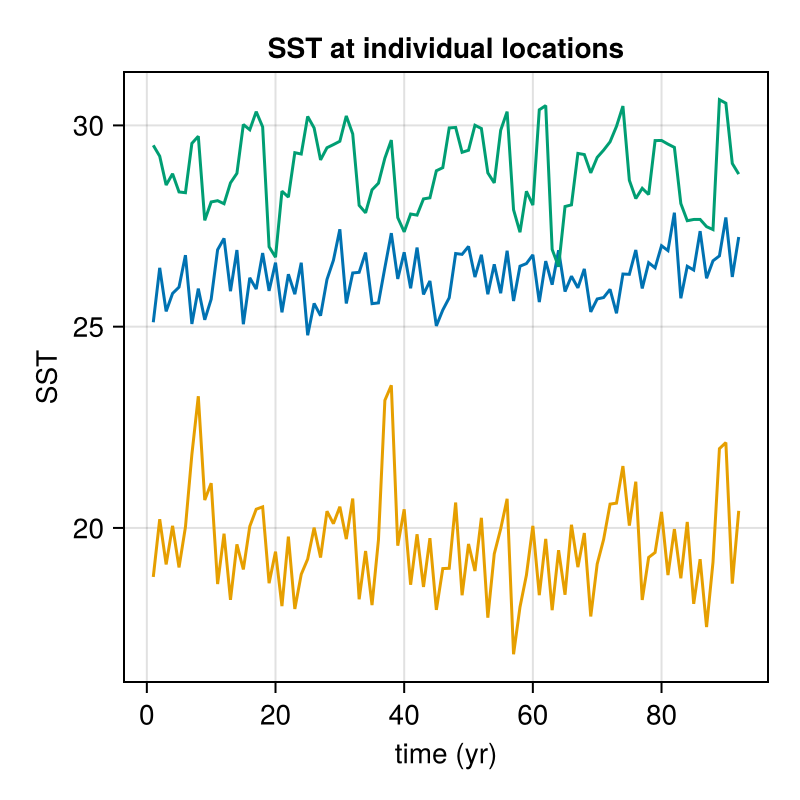

In [12]:
fig2 = Figure(;
    size = (400,400),
    )
ax = Axis(fig2[1,1];
    xlabel = "time (yr)",
    ylabel = "SST",
    title  = "SST at individual locations")
#lines!(C,ts_roni_sm, linestyle = :solid)
lines!(timeAxis1[:],sst_var[180,90,:])
lines!(timeAxis1[:],sst_var[100,80,:])
lines!(timeAxis1[:],sst_var[1,90,:])
#plot!(C,ts_roni_sm) # plots the time series using dots for the data points. 
#plot!(C,forNew)
fig2

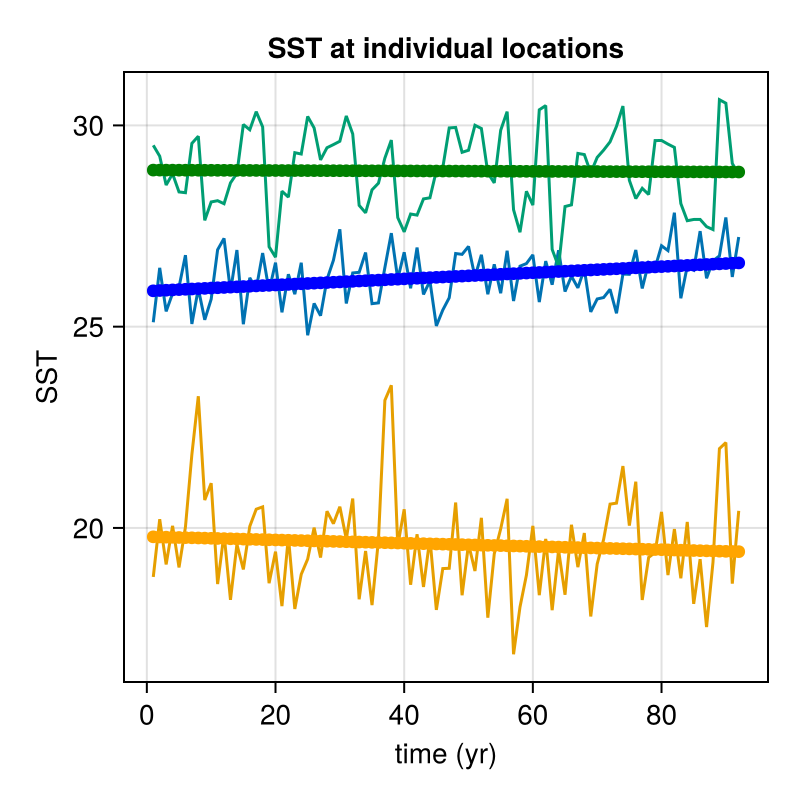

In [13]:
# generalize this cell for each grid point...

X = timeAx
X2 = Float64.(timeAx);

#Y2 = sst_var[100,80,:]
Y164 = Float64.(Y1)
Y264 = Float64.(Y2)
Y364 = Float64.(Y3)

t1 = Table(X = X2, Y = Y164);
t2 = Table(X = X2, Y = Y264);
t3 = Table(X = X2, Y = Y364);

ols1 = lm(@formula(Y ~ X), t1)
ols2 = lm(@formula(Y ~ X), t2)
ols3 = lm(@formula(Y ~ X), t3)

    plot!(X, predict(ols1), color = :blue)
    plot!(X, predict(ols2), color = :orange)
    plot!(X, predict(ols3), color = :green)

fig2

In [14]:
# save the pvalue to a variable
pvalgrid  = Array{Union{Missing, Float64}, 2}(undef, dims[1], dims[2])
pvallow   = Array{Union{Missing, Float64}, 2}(undef, dims[1], dims[2])
pvalhigh  = Array{Union{Missing, Float64}, 2}(undef, dims[1], dims[2])
intVal    = Array{Union{Missing, Float64}, 2}(undef, dims[1], dims[2])
yesp      = Array{Union{Missing, Float64}, 2}(undef, dims[1], dims[2])
#Yind      = Array{Union{Missing, Float64}, 1}(undef, dims[3])
#testVals = coeftable(ols1)
#pvalgrid[1,1] = testVals.cols[4][2] # we want to fill this whole grid with a field of pvals...

for i in 1:360 # dims[1] longitudes
    for j in 1:180 # dims[2] latitudes
        #Yind      = Array{Union{Missing, Float64}, 1}(undef, dims[3])
        Yind = sst_var[i,j,:];
        #Yind  = sst_var[1 time series]
        if any(ismissing, Yind)
            #println("missing value found ")
        else
        #Ytemp = Float64.(Yind)
        # need to somehow check if Yind contains missing data, and if so, then don't proceed to the lm step.  
            #println("missing value not found ")
            Ytemp = Float64.(Yind)
            tab   = Table(X = X2, Y = Ytemp);
            ols_temp = lm(@formula(Y ~ X), tab)
            testVals = coeftable(ols_temp)
            #pvaltemp = testVals.cols[4][2]
            pvalgrid[i,j] = testVals.cols[4][2]
            pvallow[i,j]  = testVals.cols[5][2]
            pvalhigh[i,j] = testVals.cols[6][2]
            intVal[i,j] = sign(pvalhigh[i,j]) + sign(pvallow[i,j])
        end
    end
end

In [2]:
360*180

64800

In [15]:
arrN = reshape(pvalgrid, (360*180));
testSort = sort(arrN)

64800-element Vector{Union{Missing, Float64}}:
 6.90374619231552e-23
 6.990503780745739e-22
 7.207978905866924e-22
 8.457528601648468e-22
 1.6828394799447967e-21
 6.148283223029741e-21
 1.0539051773353897e-20
 1.4229602174400755e-20
 4.3434131719194816e-20
 4.8092632396785463e-20
 5.367016279903667e-20
 5.44862318308307e-20
 6.29438681801261e-20
 ⋮
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing
  missing

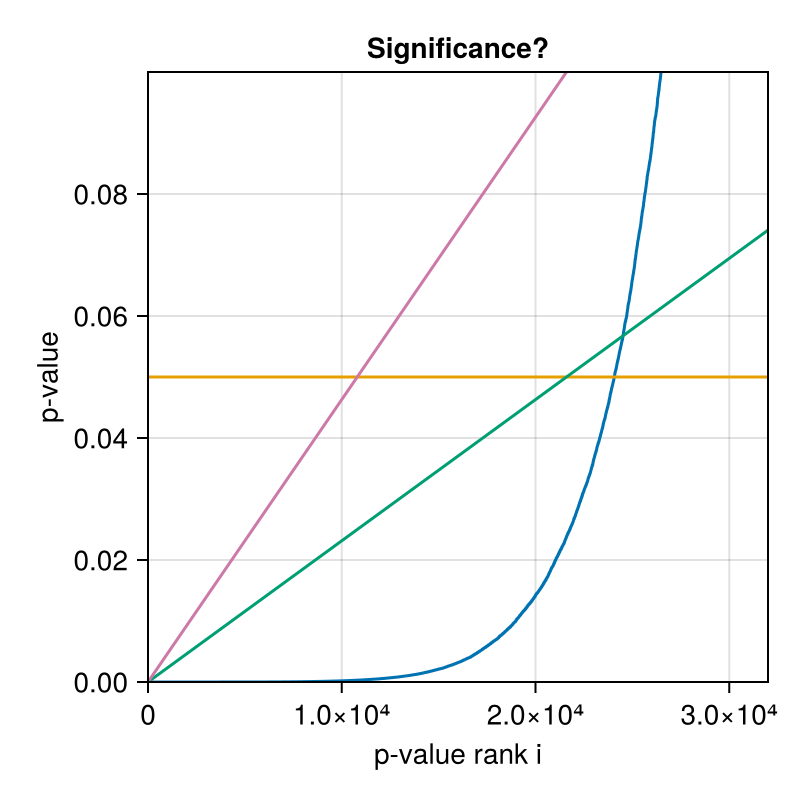

In [16]:
pAxis = collect(1:1:64800);
dlat = 60.
wilks0p05 = (0.05/(dlat*360)) .* pAxis
wilks0p1 = (0.1/(dlat*360)) .* pAxis
p0p05 = zeros(64800) .+ 0.05;
fig3 = Figure(;
    size = (400,400),
    )
ax = Axis(fig3[1,1];
    xlabel = "p-value rank i",
    ylabel = "p-value",
    title  = "Significance?",
    limits=(0,32000,0,0.1),
    )
#lines!(C,ts_roni_sm, linestyle = :solid)
lines!(ax,pAxis[:],testSort[:])
lines!(ax,pAxis[:],p0p05[:])
lines!(ax,pAxis[:],wilks0p05[:])
lines!(ax,pAxis[:],wilks0p1[:])
#lines!(timeAxis1[:],sst_var[100,80,:])
#lines!(timeAxis1[:],sst_var[1,90,:])
#plot!(C,ts_roni_sm) # plots the time series using dots for the data points. 
#plot!(C,forNew)
fig3
#plot(testSort)

In [17]:
#sign(pvalhigh[90,100]) + sign(pvallow[90,100])
# if the value of sum is zero, then the interval contains zero.
sign(-0.2) + sign(-0.04)

-2.0

In [18]:
#levs = range(0.0, 0.05, length = 21)
#local_fig(pvalgrid,lon,lat,"p values",levs)
pvalhigh[90,100]

0.012068620430701525

In [57]:
intVal[90:110,90:110]

21×21 Matrix{Union{Missing, Float64}}:
  missing  0.0       0.0       0.0       …   missing   missing   missing
  missing  0.0       0.0       0.0           missing   missing   missing
 0.0       0.0       0.0       0.0           missing   missing   missing
 0.0       0.0       0.0       0.0           missing   missing   missing
 0.0       0.0       0.0       0.0          2.0       2.0       2.0
 0.0       0.0       0.0       0.0       …  2.0       2.0       2.0
 0.0       0.0       0.0       2.0          2.0       2.0       2.0
 0.0       0.0       0.0       0.0          2.0       2.0       2.0
 0.0       0.0       0.0       0.0          2.0       2.0       2.0
 0.0       0.0       2.0       2.0          2.0       2.0       2.0
 2.0       2.0       2.0       2.0       …  2.0       2.0       2.0
  missing   missing  2.0       2.0          2.0       2.0       2.0
  missing   missing   missing  2.0          2.0       2.0       2.0
  missing   missing   missing   missing     2.0        mi

In [58]:
pvalgrid[90:110,90:110]

21×21 Matrix{Union{Missing, Float64}}:
  missing   0.97773    0.868148   0.611143     …   missing      missing
  missing   0.935343   0.398427   0.441647         missing      missing
 0.663976   0.479259   0.104985   0.408462         missing      missing
 0.774046   0.519259   0.456021   0.177323         missing      missing
 0.813783   0.604179   0.610924   0.0763894       0.0130399    0.0211949
 0.83036    0.571583   0.647587   0.0813547    …  4.47683e-6   0.00123461
 0.78242    0.227825   0.404294   0.0474001       4.42148e-6   1.73117e-7
 0.91573    0.102168   0.131073   0.215607        2.34504e-7   2.70168e-9
 0.280825   0.0840888  0.129215   0.0550226       1.21951e-9   2.9515e-9
 0.110253   0.074167   0.0283229  0.00182718      3.94993e-10  4.49416e-8
 0.0377905  0.0216481  0.0169543  0.000674025  …  1.16878e-9   1.39637e-7
  missing    missing   0.0277234  0.000176565     2.00813e-9   4.27566e-7
  missing    missing    missing   0.00140426      3.67308e-10  3.50022e-8
  missing

In [21]:
#where pvalgrid <= pvallow; set test = 1; else set test = 0
woman      = falses(dims[1],dims[2]);
c1 = coalesce.(pvalgrid, false);
c2 = coalesce.(intVal, false);
for i in 1:360
    for j in 1:180
        #woman[i,j] = pvalgrid[i,j] < 0.05 #&& intVal[i,j] != 0.0
        woman[i,j] = c1[i,j] < 0.05 && c2[i,j] != 0.0
    end
end

In [22]:
size(woman)

(360, 180)

The coalesce(x, y) function returns x if x is not missing; otherwise, it returns y. By setting y to false, any missing value is effectively replaced with false for the purpose of the boolean evaluation. This provides explicit control over how missing values are handled in logical conditions, aligning with the principle of "explicit is better than implicit."

In [23]:
# noman and woman are BitMatrixes, which are specialized 2D arrays to store boolean values
noman      = falses(dims[1],dims[2]);
noman      = pvalgrid .> pvalhigh;
noman      = coalesce.(noman, false); # --> coalesce seems to have worked to replace missing values with false values

In [24]:
typeof(woman)

BitMatrix (alias for BitArray{2})

In [25]:
noman[90:110,90:110] # noman contains 0's and 1's

21×21 BitMatrix:
 0  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  1  1  1  1  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  0  0  0  0  1  1  1  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  0  1  1  1  0  0  1  0  0  0  0  0  0  1  1
 1  1  1  1  1  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  0  0  0  1  1  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0

In [26]:

woman[90:110,90:110]

21×21 BitMatrix:
 0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0
 0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0
 0  0  0  0  0  1  1  1  1  1  0  1  1  1  1  0  0  0  0  0  0
 0  0  0  0  1  1  1  1  1  0  0  0  1  1  0  0  0  1  0  0  0
 0  0  0  0  1  1  1  1  1  1  1  1  1  1  0  0  0  1  1  1  1
 0  0  0  0  1  1  1  1  1  1  1  1  1  0  0  0  0  0  1  1  1
 0  0  0  1  1  1  1  1  1  1  1  0  1  0  0  0  0  0  1  1  1
 0  0  0  0  1  1  1  1  1  1  0  0  0  0  0  0  0  1  1  1  1
 0  0  0  0  1  1  1  1  1  0  0  0  1  1  1  1  1  1  1  1  1
 0  0  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1
 1  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1  1
 0  0  1  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1
 0  0  0  1  1  1  1  1  1  1  0  1  1  1  1  1  1  1  1  1  1
 0  0  0  0  1  1  1  1  1  0  0  1  1  1  1  1  1  1  1  0  1
 0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  0  1
 0  0  0  0  0  0  0  0  0  0  0  1  1

In [27]:
intVal[90:110,90:110]

21×21 Matrix{Union{Missing, Float64}}:
  missing  0.0       0.0       0.0       …   missing   missing   missing
  missing  0.0       0.0       0.0           missing   missing   missing
 0.0       0.0       0.0       0.0           missing   missing   missing
 0.0       0.0       0.0       0.0           missing   missing   missing
 0.0       0.0       0.0       0.0          2.0       2.0       2.0
 0.0       0.0       0.0       0.0       …  2.0       2.0       2.0
 0.0       0.0       0.0       2.0          2.0       2.0       2.0
 0.0       0.0       0.0       0.0          2.0       2.0       2.0
 0.0       0.0       0.0       0.0          2.0       2.0       2.0
 0.0       0.0       2.0       2.0          2.0       2.0       2.0
 2.0       2.0       2.0       2.0       …  2.0       2.0       2.0
  missing   missing  2.0       2.0          2.0       2.0       2.0
  missing   missing   missing  2.0          2.0       2.0       2.0
  missing   missing   missing   missing     2.0        mi

In [28]:
# grab all the points that are labelled as 'true' or 1.  
points = findall(x -> x == 1, woman); # points has dims of (24065,)
# points is now a CartesianIndex object, which cannot be directly used with scatter.  
# we have to create coordinate arrays from points: 
x_coords = [idx.I[1] for idx in points]; # x_coords has dims of (24065,)
y_coords = [idx.I[2] for idx in points];

# shift index arrays to correspond to trad lat/lon defs
x_lats = x_coords .- 180;
y_lons = y_coords .- 90;

In [29]:
size(y_coords)

(24065,)

In [30]:
x_coords[1],y_coords[1] # where are these numbers coming from?   the 5 and 15 don't seem to match those indices in 'woman'.

(5, 15)

In [31]:
x_coords[1:5],y_coords[1:20]

([5, 151, 152, 153, 3], [15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17])

In [32]:
woman[350:360,170:180]

11×11 BitMatrix:
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0

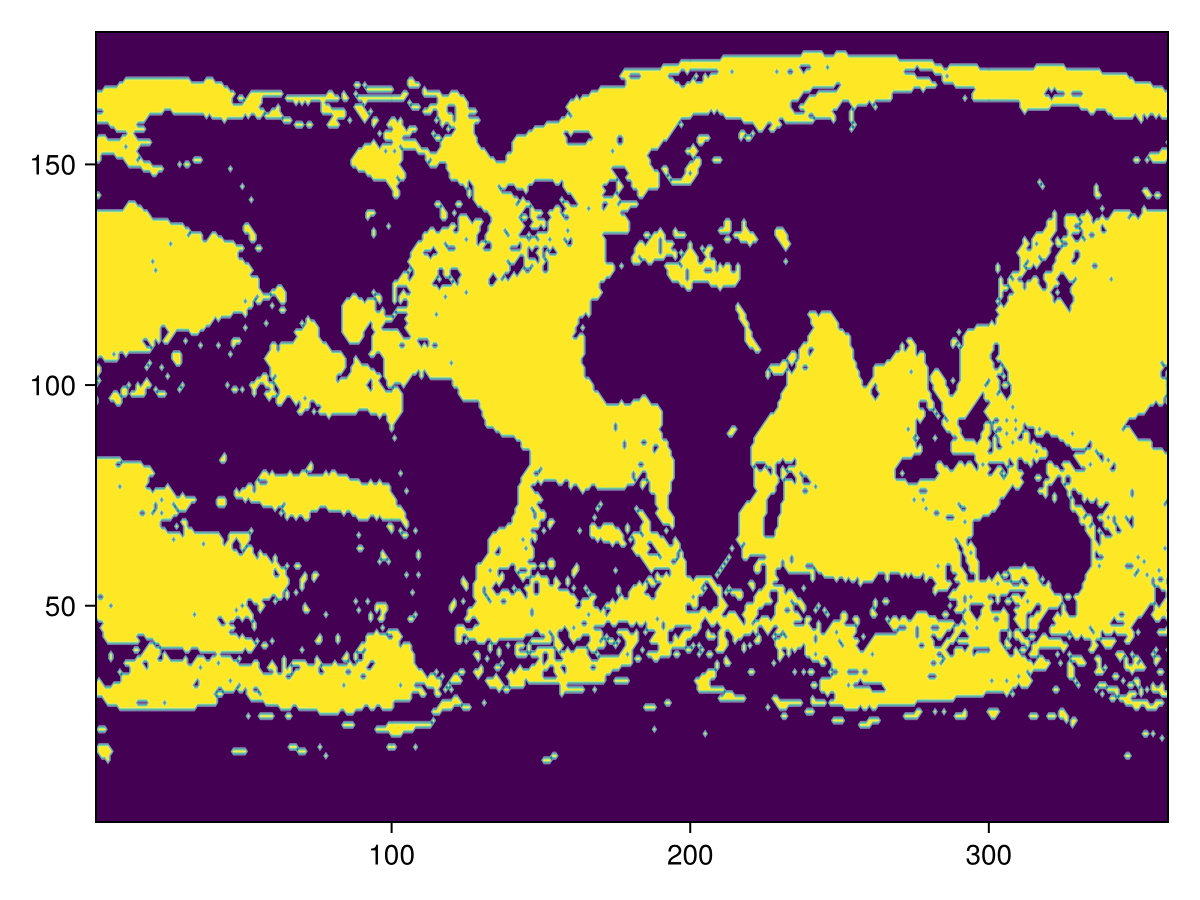

In [36]:
contourf(woman)

In [ ]:
## try to do fancy stuff with markers and colors...
#markers = [b ? :utriangle : :circle for b in noman]
#colors = [b ? :red : :blue for b in noman]

In [ ]:
levs = range(-0.5, 0.5, length = 21)
blabbb = "U+000B0"
    f3 = Figure(;
        figure_padding=(5,5,10,10),
        backgroundcolor=:white,                                                                     
        size=(900,400),                                                                             
        )   
    ax = GeoAxis(f3[1,1];
        aspect = 3,
        dest="+proj=latlon",                                                                        
        xticks = -160:20:180,                                                                       
        yticks = -30:20:30,                                                                         
        xlabel="longitude",
        ylabel="latitude",
        limits=(-160,180,-30,30),
        title="SST trend, October-November ("*blabbb*"C/decade)", 
        xticklabelsize = 14, # 14,16 are pretty reasonable sizes                                    
        yticklabelsize = 14, # 22 used for 8 panel figure that needs larger font                    
        )                                                                                           
        bb = contourf!(ax, lon, lat, agrid.*20,                                                            
             levels = levs,
             colormap = :batlow,
             #colormap = :bam, # default for shear plot (greens and pinks)
             #colormap = :seismic, # colors are a bit harsh                                         
             #colormap = :vik, # default for redish bluish for relative SST                          
             #colormap = :BrBg, # better for RH  browns and greens                                  
             #colormap = :roma,
             extendlow = :auto, extendhigh = :auto                                                  
        )       
        lines!(ax, GeoMakie.coastlines(), color = :black, linewidth=0.75)                           
        Colorbar(f3[1,2], bb)                                                                       
    #f3    
#scatter!(ax,x_vals_func,y_vals_func,color=:red,markersize=10)
#scatter!(ax,lon,lat,noman,color=:red,markersize=3)
#scatter!(ax,lon,lat,noman,color=colors,marker=markers,markersize=3)
scatter!(ax, x_lats, y_lons, marker = 'x', markersize=6, color = :black)
f3

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///Users/C823281551/code/juliaCode/In[38]#3:11\[90mIn[38]:3:11[0;0m]8;;\
blabbb = "U+000B0"
blabbb = "[48;2;120;70;70m\d[0;0megree"
[90m#         └┘ ── [0;0m[91minvalid escape sequence[0;0m

In [99]:
save("test_nlmg_pval5strict.png", f3, px_per_unit=6.0)

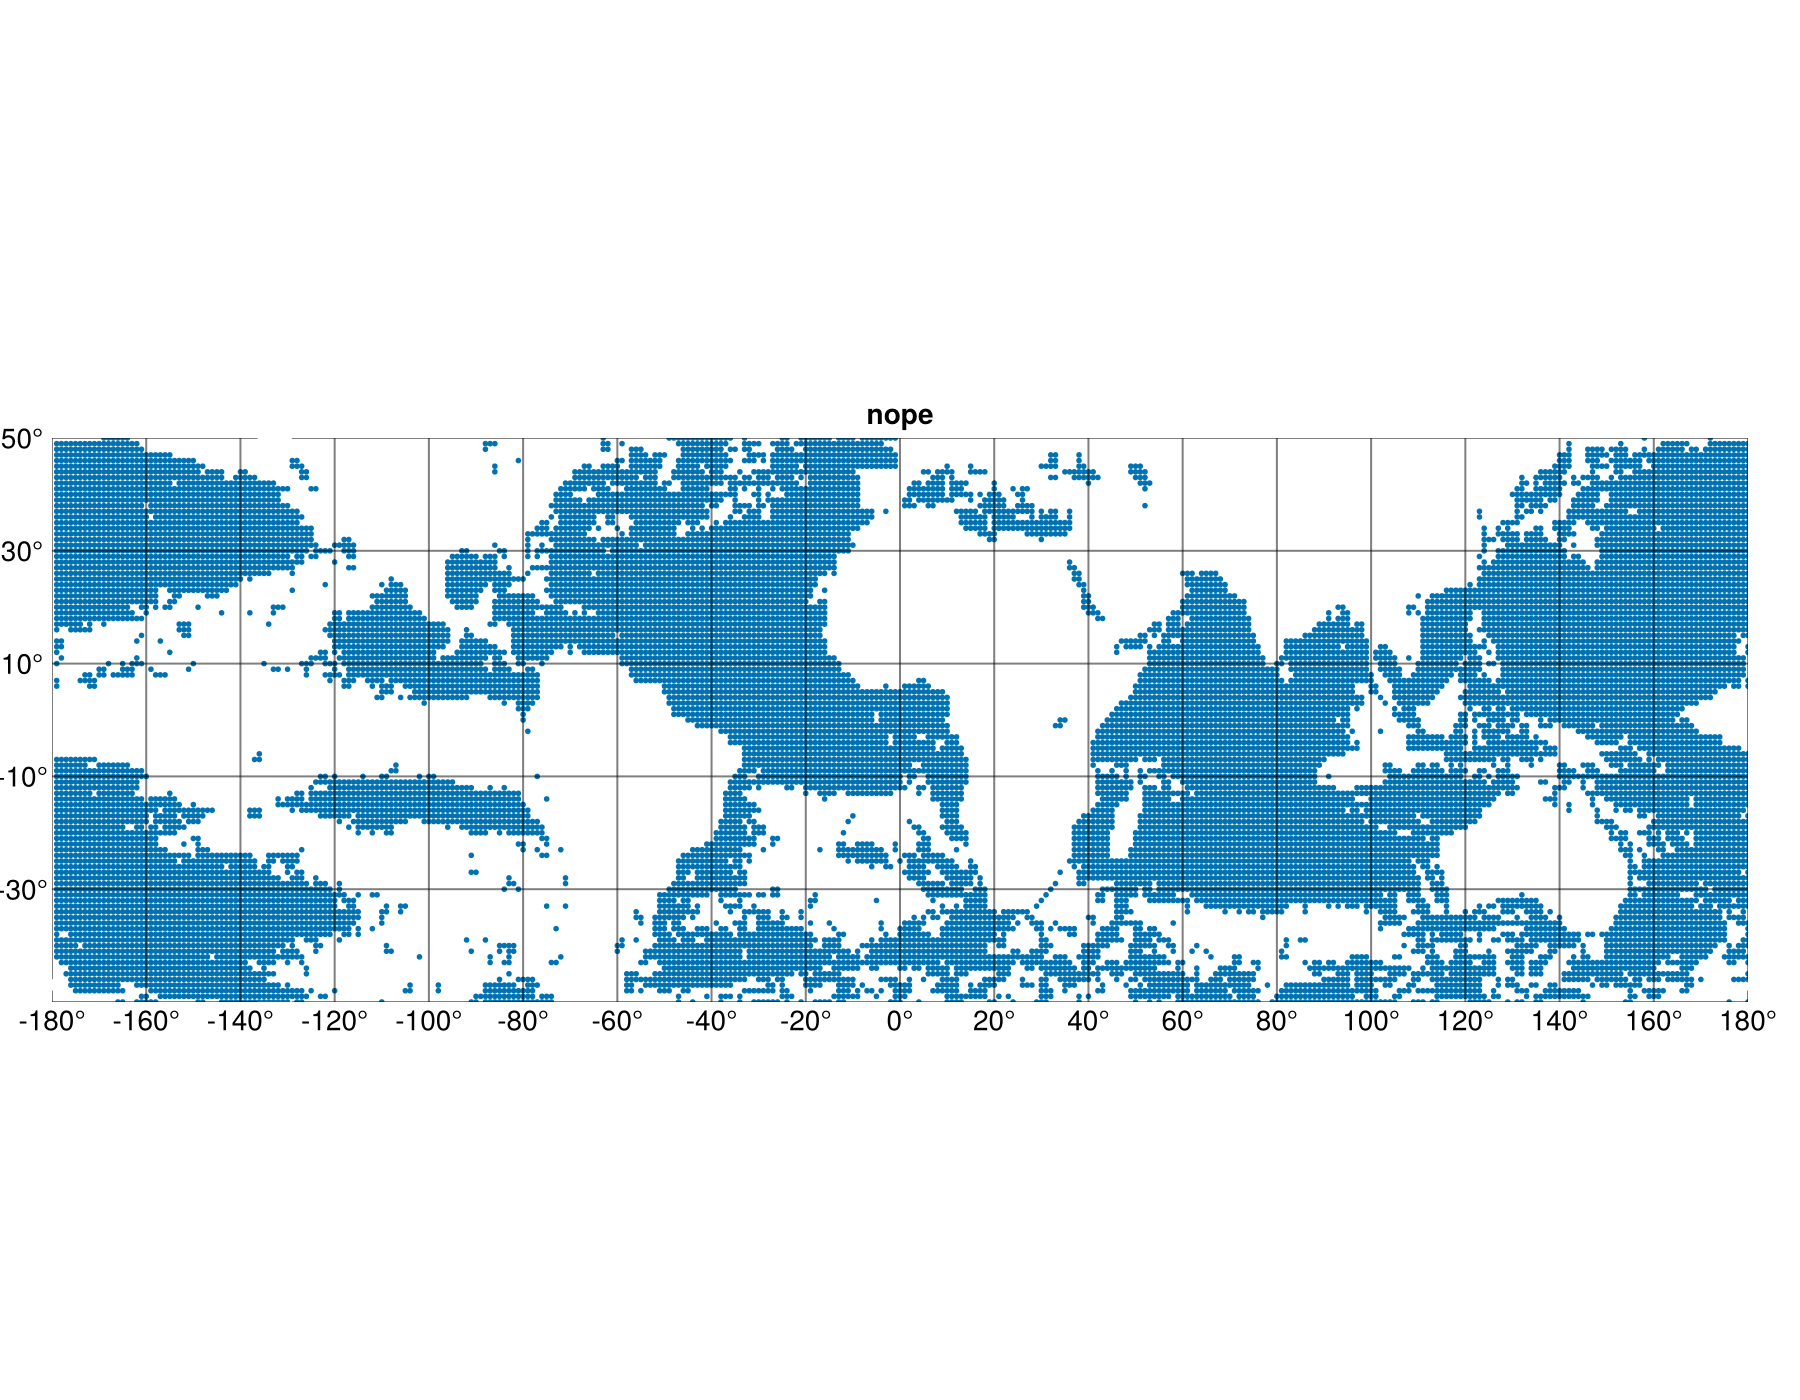

In [31]:
 f4 = Figure(;
        figure_padding=(5,5,10,10),
        backgroundcolor=:white,                                                                     
        size=(900,700),                                                                             
        )   
    ax = GeoAxis(f4[1,1];
        aspect = 3,
        dest="+proj=latlon",                                                                        
        xticks = -180:20:180,                                                                       
        yticks = -50:20:50,                                                                         
        xlabel="longitude",
        ylabel="latitude",
        limits=(-180,180,-50,50),
        title="nope", 
        xticklabelsize = 14, # 14,16 are pretty reasonable sizes                                    
        yticklabelsize = 14, # 22 used for 8 panel figure that needs larger font                    
        )                  
#scatter!(ax,lon,lat,noman, color = colors, markersize=2)#,color=colors,marker=markers,markersize=7)
#scatter!(ax,lon, lat, noman, markersize=2)
#scatter!(ax, x_coords, y_coords, markersize=4)
scatter!(ax, x_lats, y_lons, markersize = 4)
f4

using CairoMakie # Or GLMakie for interactive plots

### 1. Create data for contourf
x = range(-2, 2, length=100);
y = range(-2, 2, length=100);
f(x, y) = x^2 + y^2 # Example function;
z = [f(xi, yi) for xi in x, yi in y];

### 2. Create data for scatter plot
scatter_x = rand(10) * 4 .- 2 # Random x-coordinates;
scatter_y = rand(10) * 4 .- 2 # Random y-coordinates

### 3. Create the figure and axes
fig = Figure()
ax = Axis(fig[1, 1], title="Contourf and Scatter Overlay")

### 4. Plot contourf
contourf!(ax, x, y, z, colormap=:viridis)

### 5. Plot scatter
scatter!(ax, scatter_x, scatter_y, color=:red, markersize=10)

### 6. Display the plot
fig


In [ ]:
# blue linke, should be decent positive trend; 0.2% chance the trend is not different from zero?  or 0.2% change
# we see the given trend 'by chance'.
ols1 = lm(@formula(Y ~ X), t1)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error       t  Pr(>|t|)    Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────
(Intercept)  25.8826      0.130473    198.38    <1e-99  25.6234      26.1418
X             0.00760994  0.00243651    3.12    0.0024   0.00276939   0.0124505
───────────────────────────────────────────────────────────────────────────────

In [ ]:
testVals = coeftable(ols1)
givein = testVals.cols[4][2] #
#pvalgrid[1,1]

0.002405941724824299

#### We need to determine if the p-value for a given grid point indicates significance or not.  Should we do this with both the Lower 95% and Upper 95% or just one?   I think that if the p-value is less than the Lower 95%, or greater than the Upper 95%, most would consider that p-value to be significant.   Except for Wilks and his colleagues.

#### Once this is determined we need to indicate on a map which cells have passed the test, perhaps with a circle or dot.  Should make a grid of 1's and 0's to indicate passing cells, and then overlay it on the original map?  

In [ ]:
testVals = coeftable(ols1)
if testVals.cols[4][2] <= testVals.cols[5][2]
    print("so cold and so sweet")
else
    print("giving up")
end

so cold and so sweet

In [ ]:
# orange line, should be slightly negative trend; 41% chance the trend is not different from zero?
ols2 = lm(@formula(Y ~ X), t2)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error      t  Pr(>|t|)  Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  19.7834      0.261688    75.60    <1e-82  19.2636    20.3033
X            -0.00404738  0.00488689  -0.83    0.4097  -0.013756   0.00566128
─────────────────────────────────────────────────────────────────────────────

In [ ]:
testVals = coeftable(ols2)
if testVals.cols[4][2] <= testVals.cols[5][2]
    print("so cold and so sweet")
else
    print("giving up")
end

giving up

In [ ]:
# green line, very slight negative trend; 89% change the trend is not different from zero?
ols3 = lm(@formula(Y ~ X), t3)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                    Coef.  Std. Error       t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)  28.8897       0.209431    137.94    <1e-99  28.4736      29.3057
X            -0.000525565  0.00391101   -0.13    0.8934  -0.00829546   0.00724433
─────────────────────────────────────────────────────────────────────────────────

In [ ]:
testVals = coeftable(ols3)
if testVals.cols[4][2] <= testVals.cols[5][2]
    print("so cold and so sweet")
    # field values = 1, indicating the p-value criterion has been met
else
    print("giving up")
    # field values = 0
end

giving up

In [ ]:
# data = DataFrame(y = rand(rng, 100), x = categorical(repeat([1, 2, 3, 4], 25)));
testV = sst_var[100,80,:];
#data = DataFrame(y = sst_var[100,80,:], x = timeAx, 92);
data1 = DataFrame(y = testV, x = timeAx)
ols2 = lm(@formula(y ~ x), data1)

LoadError: MethodError: no method matching delbeta!(::GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}, ::Vector{Float32})
The function `delbeta!` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  delbeta!([91m::GLM.SparsePredChol{T}[39m, ::Vector{T}) where T
[0m[90m   @[39m [35mGLM[39m [90m~/.julia/packages/GLM/vM20T/src/[39m[90m[4mlinpred.jl:220[24m[39m
[0m  delbeta!([91m::GLM.SparsePredChol{T}[39m, ::Vector{T}, [91m::Vector{T}[39m) where T
[0m[90m   @[39m [35mGLM[39m [90m~/.julia/packages/GLM/vM20T/src/[39m[90m[4mlinpred.jl:213[24m[39m
[0m  delbeta!(::GLM.DensePredChol{T, <:LinearAlgebra.CholeskyPivoted}, [91m::Vector{T}[39m, [91m::Vector{T}[39m) where T<:Union{Float32, Float64}
[0m[90m   @[39m [35mGLM[39m [90m~/.julia/packages/GLM/vM20T/src/[39m[90m[4mlinpred.jl:159[24m[39m
[0m  ...


In [ ]:
testVals = coeftable(ols1)

|             |       Coef. | Std. Error |      t | Pr(>|t|) |   Lower 95% |  Upper 95% |
|:------------|------------:|-----------:|-------:|:---------|:------------|-----------:|
| (Intercept) | 25.8826     | 0.130473   | 198.38 |   <1e-99 | 25.6234     | 26.1418 |
| X           |  0.00760994 | 0.00243651 |   3.12 |   0.0024 |  0.00276939 |  0.0124505 |

In [ ]:
pval = testVals.cols[4][2]

0.002405941724824299

### test regression method from Tutorial.    I can't get the glm model to work on the code above, so perhaps testing it with code that worked in the doggoTut tutorial will help me to trouble shoot.  

In [ ]:
data = CSV.File("doggoTut/dataDownloaded.csv")

47-element CSV.File:
 CSV.Row: (size = 2104, price = 399900)
 CSV.Row: (size = 1600, price = 329900)
 CSV.Row: (size = 2400, price = 369000)
 CSV.Row: (size = 1416, price = 232000)
 CSV.Row: (size = 3000, price = 539900)
 CSV.Row: (size = 1985, price = 299900)
 CSV.Row: (size = 1534, price = 314900)
 CSV.Row: (size = 1427, price = 198999)
 CSV.Row: (size = 1380, price = 212000)
 CSV.Row: (size = 1494, price = 242500)
 CSV.Row: (size = 1940, price = 239999)
 CSV.Row: (size = 2000, price = 347000)
 CSV.Row: (size = 1890, price = 329999)
 ⋮
 CSV.Row: (size = 1437, price = 249900)
 CSV.Row: (size = 1239, price = 229900)
 CSV.Row: (size = 2132, price = 345000)
 CSV.Row: (size = 4215, price = 549000)
 CSV.Row: (size = 2162, price = 287000)
 CSV.Row: (size = 1664, price = 368500)
 CSV.Row: (size = 2238, price = 329900)
 CSV.Row: (size = 2567, price = 314000)
 CSV.Row: (size = 1200, price = 299000)
 CSV.Row: (size = 852, price = 179900)
 CSV.Row: (size = 1852, price = 299900)
 CSV.Row: (size =

In [ ]:
X = data.size

Y = round.(Int, data.price / 1000)

t = Table(X = X, Y = Y)

#gr(size = (600, 600))

Table with 2 columns and 47 rows:
      X     Y
    ┌──────────
 1  │ 2104  400
 2  │ 1600  330
 3  │ 2400  369
 4  │ 1416  232
 5  │ 3000  540
 6  │ 1985  300
 7  │ 1534  315
 8  │ 1427  199
 9  │ 1380  212
 10 │ 1494  242
 11 │ 1940  240
 12 │ 2000  347
 13 │ 1890  330
 14 │ 4478  700
 15 │ 1268  260
 16 │ 2300  450
 17 │ 1320  300
 18 │ 1236  200
 19 │ 2609  500
 20 │ 3031  599
 21 │ 1767  253
 22 │ 1888  255
 23 │ 1604  243
 ⋮  │  ⋮     ⋮

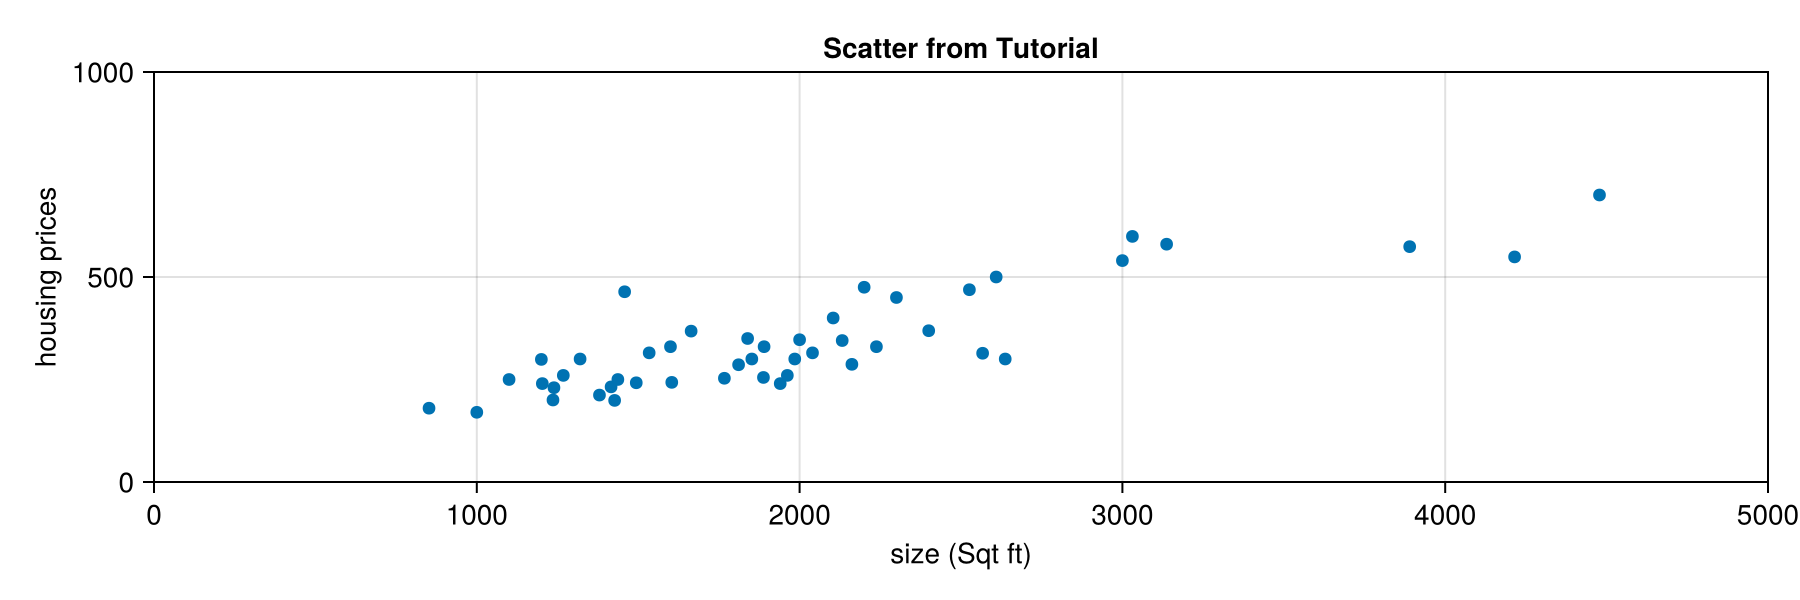

In [ ]:
fig = Figure(; size = (900,300))
ax = Axis(fig[1,1];
    xlabel="size (Sqt ft)",
    ylabel="housing prices",
    title="Scatter from Tutorial"
    )
CairoMakie.ylims!(ax, (0, 1000))
CairoMakie.xlims!(ax, (0, 5000))
#scatter!(numsA,numPosA,color=1:20,colormap=:tab20)
#scatter!(numsB,numPosB,color=1:20,colormap=:tab20, markersize = 15)
scatter!(X, Y)
fig

In [ ]:
ols = lm(@formula(Y ~ X), t)

    lines!(X, predict(ols), color = :green)

    newX = Table(X = [1250])

    predict(ols, newX)

1-element Vector{Union{Missing, Float64}}:
 239.4556726896737

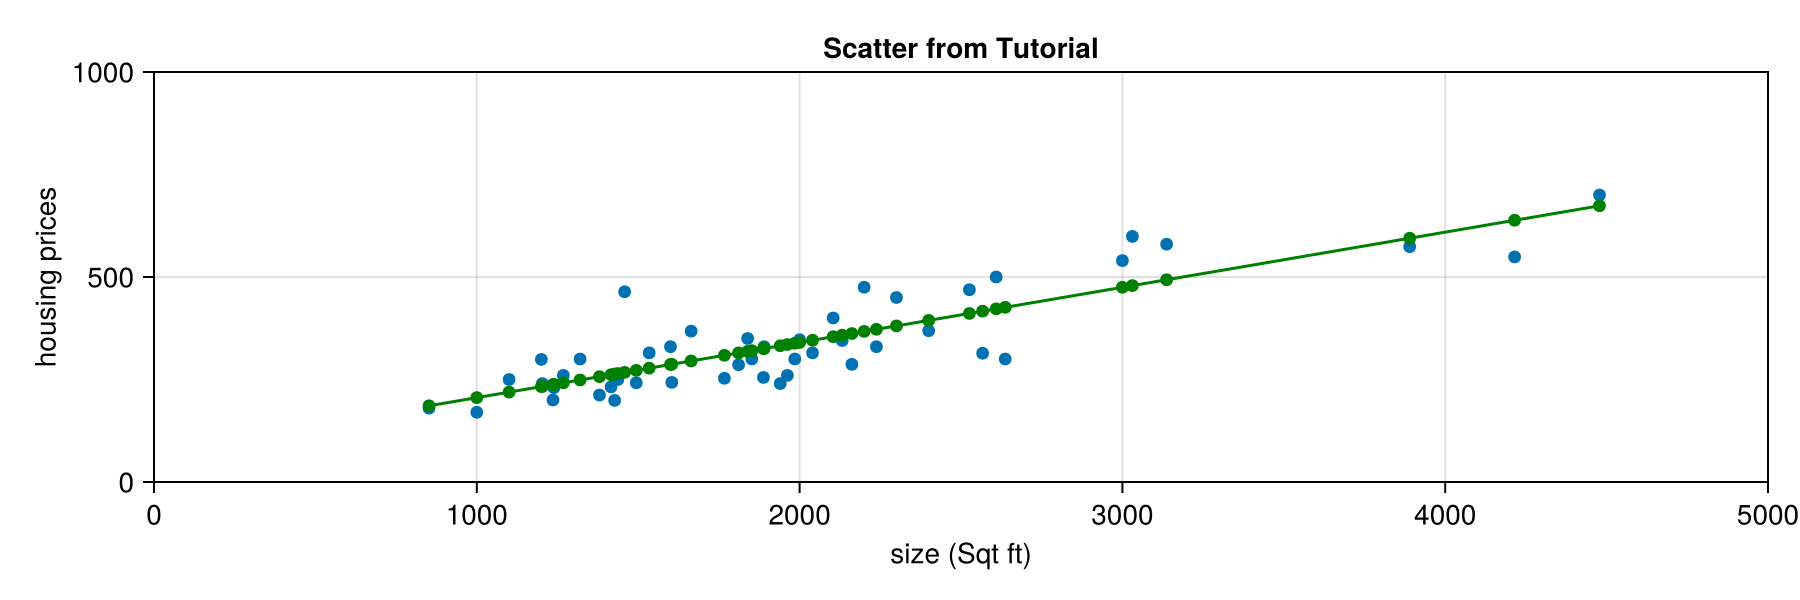

In [ ]:
fig

In [ ]:
ols = lm(@formula(Y ~ X), t)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  71.2898    26.1331      2.73    0.0091  18.655     123.925
X             0.134533   0.0121571  11.07    <1e-13   0.110047    0.159018
──────────────────────────────────────────────────────────────────────────